In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
from rdkit.Chem import AllChem
import re
import torch
from torch_geometric.data import Data, Batch

from Bio.PDB import PDBList, PDBParser, PPBuilder
from Bio import PDB

import networkx as nx
from torch_geometric.utils import from_networkx
import matplotlib.pyplot as plt

from torch_geometric.loader import DataLoader

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, GATConv, GraphConv, GraphSAGE

import random

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

from sklearn.preprocessing import StandardScaler

from ydata_profiling import ProfileReport
import os
from scipy.stats import pearsonr

In [2]:
# 固定随机种子等操作
seed = 12345
g = torch.Generator()
g.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False
torch.use_deterministic_algorithms(True)
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'
os.environ['PYTHONHASHSEED'] = str(seed)  # 为了禁止hash随机化，使得实验可复现。


# 1. datasets

## 1.1 read datasets

In [38]:
raw_data_molecule = pd.read_csv('./data/CheMBL_clean.csv')
raw_data_molecule = raw_data_molecule.sample(frac=1, random_state=seed)
raw_data_molecule.reset_index(drop=True, inplace=True)
raw_data_molecule

,ID,Smiles,IC50 (nM),canonical_smiles,Molecular Weight,LogP,num_H_acceptors,num_H_Donors
0,CHEMBL3398462,CCOC(=O)N1C[C@H](CC(=O)O)[C@@H](Cc2cccc(OCCc3n...,2120.00,CCOC(=O)N1C[C@H](CC(=O)O)[C@@H](Cc2cccc(OCCc3n...,492.572,4.99322,6,1
1,CHEMBL1082079,CCCCOc1ccc(-c2ccc(C(=O)O)cc2C)cc1CNC(=O)c1ccc(...,10.00,CCCCOc1ccc(-c2ccc(C(=O)O)cc2C)cc1CNC(=O)c1ccc(...,503.492,6.62702,3,2
2,CHEMBL257165,Cc1oc(-c2ccccc2)nc1CCOc1ccc(CC2CN(C(=O)OCC(C)C...,1250.00,Cc1oc(-c2ccccc2)nc1CCOc1ccc(CC2CN(C(=O)OCC(C)C...,520.626,5.62932,6,1
3,CHEMBL238970,CCc1cc(OCC[C@@H](C)Oc2ccc(C(F)(F)F)cc2-c2ccccn...,6095.37,CCc1cc(OCC[C@@H](C)Oc2ccc(C(F)(F)F)cc2-c2ccccn...,487.518,6.58340,4,1
4,CHEMBL4632967,CC(C)(Oc1ccc(CCOc2ccc(NC(=O)Nc3ccccc3)cc2)cc1)...,1520.00,CC(C)(Oc1ccc(CCOc2ccc(NC(=O)Nc3ccccc3)cc2)cc1)...,573.671,5.61460,6,3
...,...,...,...,...,...,...,...,...
978,CHEMBL1760267,CCCCN(c1cccc(-c2ccc(Cl)cc2)c1C)S(=O)(=O)c1ccc(...,19952.62,CCCCN(c1cccc(-c2ccc(Cl)cc2)c1C)S(=O)(=O)c1ccc(...,530.086,6.77956,4,1
979,CHEMBL78529,CCC(Cc1ccc(OCCc2nc(-c3ccccc3)oc2C)cc1)(Oc1cccc...,473.00,CCC(Cc1ccc(OCCc2nc(-c3ccccc3)oc2C)cc1)(Oc1cccc...,471.553,6.12642,5,1
980,CHEMBL92130,CCCc1cc(Oc2ccc(OC)cc2)ccc1OCCCOc1cccc(C2SC(=O)...,2550.00,CCCc1cc(Oc2ccc(OC)cc2)ccc1OCCCOc1cccc(C2SC(=O)...,507.608,6.31200,7,1
981,CHEMBL214026,Cc1cc(OCC[C@@H](C)Oc2ccc(Cl)cc2Oc2ccccc2)ccc1C...,5308.84,Cc1cc(OCC[C@@H](C)Oc2ccc(Cl)cc2Oc2ccccc2)ccc1C...,454.950,6.69432,4,1


In [39]:
print(raw_data_molecule.columns)

Index(['ID', 'Smiles', 'IC50 (nM)', 'canonical_smiles', 'Molecular Weight',
       'LogP', 'num_H_acceptors', 'num_H_Donors'],
      dtype='object')


## 1.4 missing data and duplicated data

In [40]:
raw_data_molecule_copy = raw_data_molecule.dropna(subset=['IC50 (nM)'])
raw_data_molecule_copy = raw_data_molecule_copy.drop_duplicates(subset='Smiles')
raw_data_molecule_copy = raw_data_molecule_copy.reset_index(drop=True)
raw_data_molecule_copy

,ID,Smiles,IC50 (nM),canonical_smiles,Molecular Weight,LogP,num_H_acceptors,num_H_Donors
0,CHEMBL3398462,CCOC(=O)N1C[C@H](CC(=O)O)[C@@H](Cc2cccc(OCCc3n...,2120.00,CCOC(=O)N1C[C@H](CC(=O)O)[C@@H](Cc2cccc(OCCc3n...,492.572,4.99322,6,1
1,CHEMBL1082079,CCCCOc1ccc(-c2ccc(C(=O)O)cc2C)cc1CNC(=O)c1ccc(...,10.00,CCCCOc1ccc(-c2ccc(C(=O)O)cc2C)cc1CNC(=O)c1ccc(...,503.492,6.62702,3,2
2,CHEMBL257165,Cc1oc(-c2ccccc2)nc1CCOc1ccc(CC2CN(C(=O)OCC(C)C...,1250.00,Cc1oc(-c2ccccc2)nc1CCOc1ccc(CC2CN(C(=O)OCC(C)C...,520.626,5.62932,6,1
3,CHEMBL238970,CCc1cc(OCC[C@@H](C)Oc2ccc(C(F)(F)F)cc2-c2ccccn...,6095.37,CCc1cc(OCC[C@@H](C)Oc2ccc(C(F)(F)F)cc2-c2ccccn...,487.518,6.58340,4,1
4,CHEMBL4632967,CC(C)(Oc1ccc(CCOc2ccc(NC(=O)Nc3ccccc3)cc2)cc1)...,1520.00,CC(C)(Oc1ccc(CCOc2ccc(NC(=O)Nc3ccccc3)cc2)cc1)...,573.671,5.61460,6,3
...,...,...,...,...,...,...,...,...
978,CHEMBL1760267,CCCCN(c1cccc(-c2ccc(Cl)cc2)c1C)S(=O)(=O)c1ccc(...,19952.62,CCCCN(c1cccc(-c2ccc(Cl)cc2)c1C)S(=O)(=O)c1ccc(...,530.086,6.77956,4,1
979,CHEMBL78529,CCC(Cc1ccc(OCCc2nc(-c3ccccc3)oc2C)cc1)(Oc1cccc...,473.00,CCC(Cc1ccc(OCCc2nc(-c3ccccc3)oc2C)cc1)(Oc1cccc...,471.553,6.12642,5,1
980,CHEMBL92130,CCCc1cc(Oc2ccc(OC)cc2)ccc1OCCCOc1cccc(C2SC(=O)...,2550.00,CCCc1cc(Oc2ccc(OC)cc2)ccc1OCCCOc1cccc(C2SC(=O)...,507.608,6.31200,7,1
981,CHEMBL214026,Cc1cc(OCC[C@@H](C)Oc2ccc(Cl)cc2Oc2ccccc2)ccc1C...,5308.84,Cc1cc(OCC[C@@H](C)Oc2ccc(Cl)cc2Oc2ccccc2)ccc1C...,454.950,6.69432,4,1


In [41]:
change_type = raw_data_molecule_copy['IC50 (nM)'].astype('float32')
raw_data_molecule_copy['IC50 (nM)'] = change_type

In [42]:
raw_data_molecule_copy['pIC50'] = raw_data_molecule_copy['IC50 (nM)'].apply(lambda x: -np.log10(x * 10 ** (-9)))

In [43]:
raw_data_molecule_copy = raw_data_molecule_copy[raw_data_molecule_copy['pIC50'] >= 4.0]

In [44]:
raw_data_molecule = raw_data_molecule_copy.reset_index(drop=True)
print(raw_data_molecule.isna().sum())
print(raw_data_molecule.nunique())
raw_data_molecule

ID                  0
Smiles              0
IC50 (nM)           0
canonical_smiles    0
Molecular Weight    0
LogP                0
num_H_acceptors     0
num_H_Donors        0
pIC50               0
dtype: int64
ID                  981
Smiles              981
IC50 (nM)           543
canonical_smiles    981
Molecular Weight    725
LogP                759
num_H_acceptors       9
num_H_Donors          5
pIC50               543
dtype: int64


,ID,Smiles,IC50 (nM),canonical_smiles,Molecular Weight,LogP,num_H_acceptors,num_H_Donors,pIC50
0,CHEMBL3398462,CCOC(=O)N1C[C@H](CC(=O)O)[C@@H](Cc2cccc(OCCc3n...,2120.000000,CCOC(=O)N1C[C@H](CC(=O)O)[C@@H](Cc2cccc(OCCc3n...,492.572,4.99322,6,1,5.673664
1,CHEMBL1082079,CCCCOc1ccc(-c2ccc(C(=O)O)cc2C)cc1CNC(=O)c1ccc(...,10.000000,CCCCOc1ccc(-c2ccc(C(=O)O)cc2C)cc1CNC(=O)c1ccc(...,503.492,6.62702,3,2,8.000000
2,CHEMBL257165,Cc1oc(-c2ccccc2)nc1CCOc1ccc(CC2CN(C(=O)OCC(C)C...,1250.000000,Cc1oc(-c2ccccc2)nc1CCOc1ccc(CC2CN(C(=O)OCC(C)C...,520.626,5.62932,6,1,5.903090
3,CHEMBL238970,CCc1cc(OCC[C@@H](C)Oc2ccc(C(F)(F)F)cc2-c2ccccn...,6095.370117,CCc1cc(OCC[C@@H](C)Oc2ccc(C(F)(F)F)cc2-c2ccccn...,487.518,6.58340,4,1,5.215000
4,CHEMBL4632967,CC(C)(Oc1ccc(CCOc2ccc(NC(=O)Nc3ccccc3)cc2)cc1)...,1520.000000,CC(C)(Oc1ccc(CCOc2ccc(NC(=O)Nc3ccccc3)cc2)cc1)...,573.671,5.61460,6,3,5.818156
...,...,...,...,...,...,...,...,...,...
976,CHEMBL1760267,CCCCN(c1cccc(-c2ccc(Cl)cc2)c1C)S(=O)(=O)c1ccc(...,19952.619141,CCCCN(c1cccc(-c2ccc(Cl)cc2)c1C)S(=O)(=O)c1ccc(...,530.086,6.77956,4,1,4.700000
977,CHEMBL78529,CCC(Cc1ccc(OCCc2nc(-c3ccccc3)oc2C)cc1)(Oc1cccc...,473.000000,CCC(Cc1ccc(OCCc2nc(-c3ccccc3)oc2C)cc1)(Oc1cccc...,471.553,6.12642,5,1,6.325139
978,CHEMBL92130,CCCc1cc(Oc2ccc(OC)cc2)ccc1OCCCOc1cccc(C2SC(=O)...,2550.000000,CCCc1cc(Oc2ccc(OC)cc2)ccc1OCCCOc1cccc(C2SC(=O)...,507.608,6.31200,7,1,5.593460
979,CHEMBL214026,Cc1cc(OCC[C@@H](C)Oc2ccc(Cl)cc2Oc2ccccc2)ccc1C...,5308.839844,Cc1cc(OCC[C@@H](C)Oc2ccc(Cl)cc2Oc2ccccc2)ccc1C...,454.950,6.69432,4,1,5.275000


# 2. construct graphs for small molecules

In [45]:
# Define possible values for one-hot encoding
possible_atomic_numbers = list(range(1, 119))
possible_degrees = list(range(0, 10))
possible_hybridizations = [
    Chem.rdchem.HybridizationType.SP,
    Chem.rdchem.HybridizationType.SP2,
    Chem.rdchem.HybridizationType.SP3,
    Chem.rdchem.HybridizationType.SP3D,
    Chem.rdchem.HybridizationType.SP3D2
]
possible_chirality = [
    Chem.rdchem.ChiralType.CHI_UNSPECIFIED,
    Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW,
    Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW,
    Chem.rdchem.ChiralType.CHI_OTHER
]
possible_bond_types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE,
                       Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]

possible_bond_stereo = [Chem.rdchem.BondStereo.STEREONONE, Chem.rdchem.BondStereo.STEREOZ,
                        Chem.rdchem.BondStereo.STEREOE, Chem.rdchem.BondStereo.STEREOCIS,
                        Chem.rdchem.BondStereo.STEREOTRANS]

# One-hot encoding functions
def one_hot_encode(value, possible_values):
    encoding = [0] * len(possible_values)
    if value in possible_values:
        encoding[possible_values.index(value)] = 1
    return encoding

# Functions for molecular data processing
def get_atomic_info(atom):
    atomic_number_encoding = one_hot_encode(atom.GetAtomicNum(), possible_atomic_numbers)
    degree_encoding = one_hot_encode(atom.GetTotalDegree(), possible_degrees)
    hybridization_encoding = one_hot_encode(atom.GetHybridization(), possible_hybridizations)
    aromatic_encoding = [1 if atom.GetIsAromatic() else 0]
    implicit_valence_encoding = one_hot_encode(atom.GetImplicitValence(), possible_degrees)
    formal_charge_encoding = [atom.GetFormalCharge()]
    chirality_encoding = one_hot_encode(atom.GetChiralTag(), possible_chirality)

    return atomic_number_encoding + degree_encoding + hybridization_encoding + \
           aromatic_encoding + implicit_valence_encoding + formal_charge_encoding + chirality_encoding

def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    atom_features = [get_atomic_info(atom) for atom in mol.GetAtoms()]
    x = torch.tensor(atom_features, dtype=torch.float)

    edges = []
    edge_features = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edges.append((i, j))
        edges.append((j, i))

        bond_type_encoding = one_hot_encode(bond.GetBondType(), possible_bond_types)
        bond_stereo_encoding = one_hot_encode(bond.GetStereo(), possible_bond_stereo)
        conjugation_encoding = [1 if bond.GetIsConjugated() else 0]
        edge_feature = bond_type_encoding + bond_stereo_encoding + conjugation_encoding

        edge_features.append(edge_feature)
        edge_features.append(edge_feature)

    edge_index = torch.tensor(edges, dtype=torch.int64).t().contiguous()
    edge_attr = torch.tensor(edge_features, dtype=torch.float)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

In [46]:
graph_list = [smiles_to_graph(smile) for smile in raw_data_molecule['Smiles']]
pIC50_list = raw_data_molecule['pIC50'].to_list()

scaler = StandardScaler()
pIC50_list = scaler.fit_transform(np.array(pIC50_list).reshape(-1, 1)).flatten()

for graph, pIC50 in zip(graph_list, pIC50_list):
    graph.y = torch.tensor([pIC50], dtype=torch.float).view(-1, 1)


drug_graphs = graph_list
drug_graphs[0]


Data(x=[36, 149], edge_index=[2, 78], edge_attr=[78, 10], y=[1, 1])

# 3. construct graphs for protein

In [47]:
# Define a mapping from amino acid names to one-hot encoded vectors
amino_acids = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLU', 'GLN', 'GLY', 'HIS', 'ILE', 
               'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL']
amino_acid_dict = {aa: idx for idx, aa in enumerate(amino_acids)}

In [48]:
def one_hot_encode_amino_acid(residue_name):
    one_hot = [0] * len(amino_acids)
    if residue_name in amino_acid_dict:
        one_hot[amino_acid_dict[residue_name]] = 1
    return one_hot


def pdb_to_graph(pdb_id):
    pdb_list = PDBList()
    pdb_file_path = pdb_list.retrieve_pdb_file(pdb_id, file_format='pdb', pdir='.')

    parser = PDBParser(QUIET=True)
    structure = parser.get_structure(pdb_id, pdb_file_path)

    # Create a graph
    G = nx.Graph()

    # Traverse through the hierarchy
    for model in structure:
        for chain in model:
            for residue in chain:
                res_id = residue.get_id()
                residue_name = residue.get_resname()
                node_feature = one_hot_encode_amino_acid(residue_name)

                # Additional features: secondary structure and B-factor
                b_factor = residue["CA"].get_bfactor() if 'CA' in residue else 0.0
                
                # Combine all features
                node_feature.append(b_factor)

                G.add_node(res_id, residue_name=residue_name, feature=node_feature)

    # Add edges based on distance threshold
    threshold = 5.0  # Angstroms
    for residue1 in structure.get_residues():
        for residue2 in structure.get_residues():
            if residue1 != residue2:
                try:
                    distance = residue1['CA'] - residue2['CA']  # Using alpha carbon (CA) distance
                    if distance < threshold:
                        G.add_edge(residue1.get_id(), residue2.get_id(), distance=distance)
                except KeyError:
                    continue

    # Convert to PyTorch Geometric Data format
    data = from_networkx(G)

    # Convert node features to tensor and assign to data.x
    node_features = [G.nodes[n]['feature'] for n in G.nodes]
    data.x = torch.tensor(node_features, dtype=torch.float)

    # Optionally add edge attributes if necessary
    edge_attr = [G[u][v]['distance'] for u, v in G.edges]
    data.edge_attr = torch.tensor(edge_attr, dtype=torch.float).view(-1, 1)


    return data

In [49]:
protein_pdb = '4NKI'
protein_graph = pdb_to_graph(protein_pdb)
protein_graph

Structure exists: '.\pdb4nki.ent' 


Data(edge_index=[2, 694], residue_name=[359], feature=[359, 21], distance=[694], num_nodes=359, x=[359, 21], edge_attr=[347, 1])

# 4. datasets preparation

shuffling the dataset before it is split can improve the performance. When downloading the dataset from CheMBL, the compound may be sorted and ranked. 

In [50]:
batch_size = 64
torch.manual_seed(seed)
drug_graph_train_loader = DataLoader(drug_graphs[0: int(len(drug_graphs) * 0.8)], batch_size=batch_size, shuffle=True)
drug_graph_test_loader = DataLoader(drug_graphs[int(len(drug_graphs) * 0.2): ], batch_size=batch_size, shuffle=False)

# 5. model construction

In [51]:
class GCN_Graph(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN_Graph, self).__init__()
        torch.manual_seed(seed)
        self.conv1 = GraphConv(in_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, out_channels)

    
    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.leaky_relu(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.leaky_relu(x)

        x = global_mean_pool(x, batch)  # Global pooling

        x = F.dropout(x, p=0.5, training=self.training)
        
        x = self.lin(x)

        return x


class AffinityPredictor(torch.nn.Module):
    def __init__(self, protein_gnn, molecule_gnn, hidden_channels):
        super(AffinityPredictor, self).__init__()
        torch.manual_seed(seed)
        self.protein_gnn = protein_gnn
        self.molecule_gnn = molecule_gnn
        self.lin = torch.nn.Linear(hidden_channels * 2, hidden_channels * 2)
        self.batch = torch.nn.BatchNorm1d(hidden_channels * 2)
        self.fc = torch.nn.Linear(hidden_channels * 2, 1)
    
    def forward(self, protein_data, molecule_data):
        # Protein embedding
        protein_embedding = self.protein_gnn(protein_data.x, protein_data.edge_index, protein_data.batch)
        protein_embedding = protein_embedding.unsqueeze(0).expand(molecule_data.batch.max().item() + 1, -1, -1)  # Expand for batch size
        protein_embedding = protein_embedding.reshape(-1, protein_embedding.size(-1))  # Reshape to match molecule_embedding
        # Molecule embedding
        molecule_embedding = self.molecule_gnn(molecule_data.x, molecule_data.edge_index, molecule_data.batch)
        
        # Concatenate embeddings
        x = torch.cat([protein_embedding, molecule_embedding], dim=1)
        x = self.lin(x)
        x = self.batch(x)
        x = F.leaky_relu(x)
        
        x = F.dropout(x, p=0.5, training=self.training)
        
        return self.fc(x)


# 6. initializing the model

In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
protein_gnn = GCN_Graph(in_channels=protein_graph.num_node_features, hidden_channels=128, out_channels=128).to(device)
molecule_gnn = GCN_Graph(in_channels=drug_graphs[0].num_node_features, hidden_channels=128, out_channels=128).to(device)
model = AffinityPredictor(protein_gnn, molecule_gnn, hidden_channels=128).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

criterion = torch.nn.L1Loss(reduction='mean').to(device)

Using device: cuda


# 7. train and test
rule of thumb: either MAE < 0.6 or R2 > 0.6 is considered as good model
https://www.nature.com/articles/s41598-020-80113-7

In [53]:
def train(model, protein_graph, drug_graph_train_loader, optimizer, criterion, epoch):
    model.train()

    for molecule_data in drug_graph_train_loader:
        
        optimizer.zero_grad()
        molecule_data = molecule_data.to(device)
        protein_graph = protein_graph.to(device)
        
        protein_graph_batch = protein_graph.clone()
        protein_graph_batch.batch = torch.zeros(protein_graph.x.size(0), dtype=torch.long).to(device)
        
        output = model(protein_graph, molecule_data)
        loss = criterion(output, molecule_data.y)
        loss.backward()
        optimizer.step()
    

def test(protein_graph, loader):
    model.eval()

    loss_list = []
    r2_list = []

    with torch.no_grad():
        for data in loader:
            
            protein_graph = protein_graph.to(device)
            data = data.to(device)
            out = model(protein_graph, data)
   
            out = torch.tensor(scaler.inverse_transform(out.detach().cpu().numpy().reshape(-1, 1)).flatten())
            actual = torch.tensor(scaler.inverse_transform(data.y.detach().cpu().numpy().reshape(-1, 1)).flatten())

            mae_loss = criterion(out, actual)

            r2 = r2_score(actual, out)
            r2_list.append(r2)

            mae_loss = mae_loss.detach().cpu().numpy()
            loss_list.append(mae_loss)
            
    return loss_list, r2_list
        
overall_train_r2 = []
overall_test_r2 = []
overall_train_loss = []
overall_test_loss = []

best_loss = float('inf')
patience = 100
patience_counter = 0
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
# Training loop
for epoch in range(1, 2001):
    train(model,protein_graph, drug_graph_train_loader, optimizer, criterion, epoch)

    if epoch % 1 == 0:
        train_loss, r2_train_list = test(protein_graph, drug_graph_train_loader)
        test_loss, r2_test_list = test(protein_graph, drug_graph_test_loader)
        print(f'Epoch {epoch}, MAE train loss: {np.average(train_loss):.4f}, MAE test loss: {np.average(test_loss):.4f}, train r2: {np.average(r2_train_list):.4f}, test r2: {np.average(r2_test_list):.4f}')

        overall_train_loss.append(np.average(train_loss))
        overall_test_loss.append(np.average(test_loss))

        overall_train_r2.append(np.average(r2_train_list))
        overall_test_r2.append(np.average(r2_test_list))


        if np.average(test_loss) < best_loss:
            best_loss = np.average(test_loss)
            patience_counter = 0
            # torch.save(model.state_dict(), 'best_model_no_fingerprint_GraphConv.pth')
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print("Early stopping")
            break
    scheduler.step()

Epoch 1, MAE train loss: 0.8624, MAE test loss: 0.8369, train r2: -0.0110, test r2: 0.0057
Epoch 2, MAE train loss: 0.8420, MAE test loss: 0.8116, train r2: 0.0606, test r2: 0.0667
Epoch 3, MAE train loss: 0.7591, MAE test loss: 0.7542, train r2: 0.1850, test r2: 0.1904
Epoch 4, MAE train loss: 0.7208, MAE test loss: 0.7191, train r2: 0.2444, test r2: 0.2408
Epoch 5, MAE train loss: 0.7116, MAE test loss: 0.7055, train r2: 0.2685, test r2: 0.2648
Epoch 6, MAE train loss: 0.6470, MAE test loss: 0.6293, train r2: 0.3564, test r2: 0.3683
Epoch 7, MAE train loss: 0.6677, MAE test loss: 0.6777, train r2: 0.2485, test r2: 0.2423
Epoch 8, MAE train loss: 0.6424, MAE test loss: 0.6297, train r2: 0.3685, test r2: 0.3757
Epoch 9, MAE train loss: 0.6035, MAE test loss: 0.6186, train r2: 0.4150, test r2: 0.3840
Epoch 10, MAE train loss: 0.5942, MAE test loss: 0.5967, train r2: 0.4141, test r2: 0.4079
Epoch 11, MAE train loss: 0.6464, MAE test loss: 0.6321, train r2: 0.3336, test r2: 0.3389
Epoch 1

In [54]:
print('r2 on testset', np.average(overall_test_r2[400:]))
print('MAE on testset',np.average(overall_test_loss[400:]))

r2 on testset 0.680070438707663
MAE on testset 0.38443133


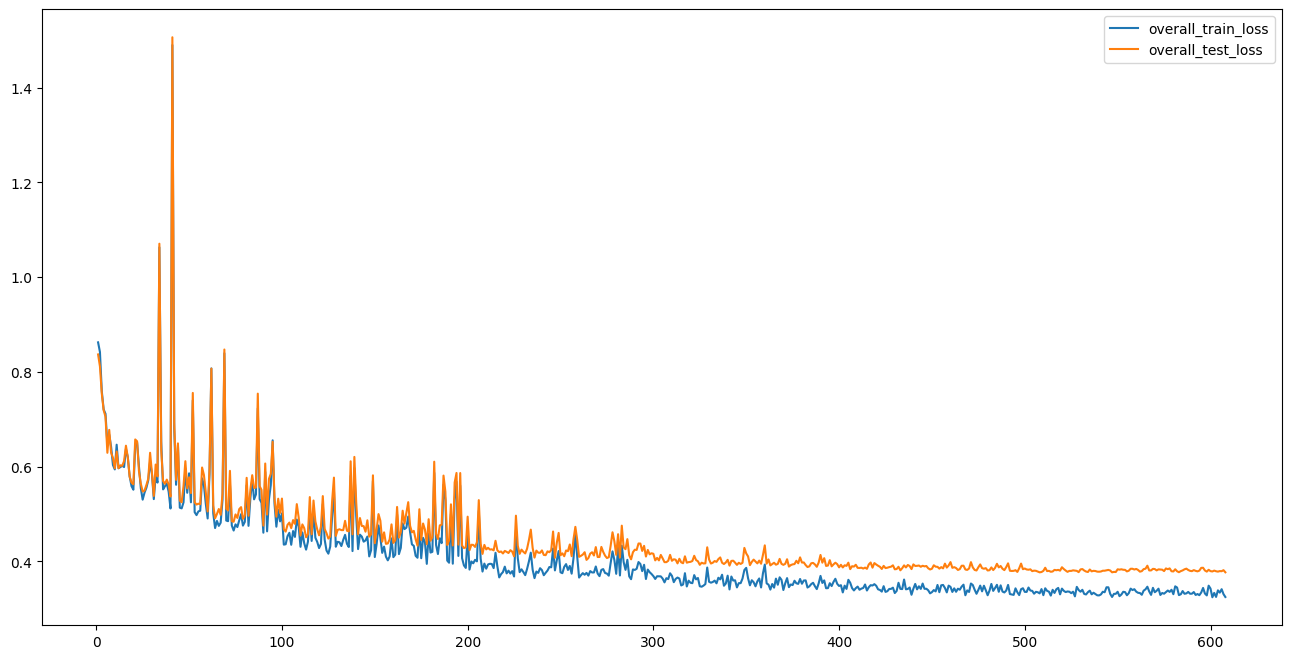

In [55]:
x = [i for i in range(1, 609)]
fig = plt.figure(figsize=(16, 8))
plt.plot(x, overall_train_loss, label = 'overall_train_loss')
plt.plot(x, overall_test_loss, label = 'overall_test_loss')
plt.legend()
plt.show()
# fig.savefig('./mae_no_fingerprint_GraphConv.png')

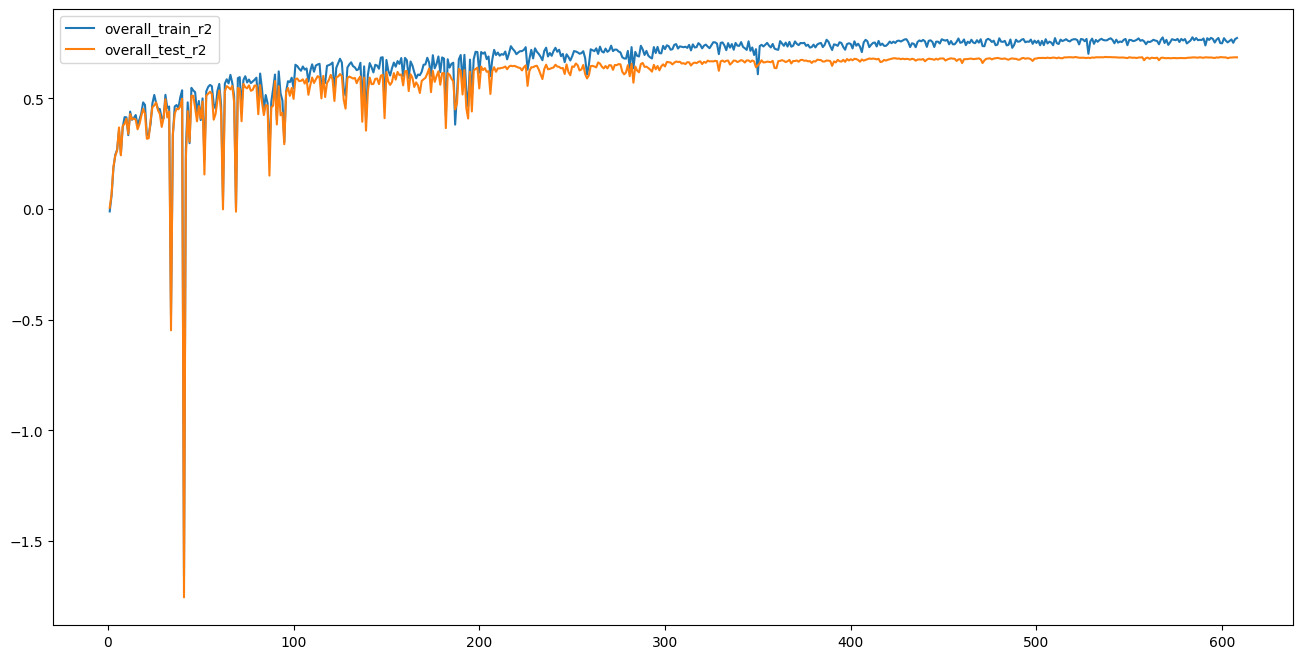

In [56]:
fig = plt.figure(figsize=(16, 8))
plt.plot(x, overall_train_r2, label = 'overall_train_r2')
plt.plot(x, overall_test_r2, label = 'overall_test_r2')
plt.legend()
plt.show()
# fig.savefig('./r2_no_fingerprint_GraphConv.png')

# 8. Validation on BindingDB dataset

In [58]:
CheMBL = pd.read_csv('./data/BindingDB clean.csv')
CheMBL = CheMBL.sample(frac=1, random_state=seed)
CheMBL = CheMBL.reset_index(drop=True)
CheMBL

,ID,Smiles,IC50 (nM),canonical_smiles,Molecular Weight,LogP,num_H_acceptors,num_H_Donors
0,50297101,Cc1oc(nc1CCOc1cccc(C[C@H]2CN(C[C@H]2C(O)=O)c2n...,1120.00,Cc1oc(-c2ccccc2)nc1CCOc1cccc(C[C@H]2CN(c3nccc(...,552.553,5.46002,7,1
1,50510299,CCCCCCCCCCCC\C=C(/CCCC(O)=O)[N+]([O-])=O,15000.00,CCCCCCCCCCCC/C=C(\CCCC(=O)O)[N+](=O)[O-],327.465,5.71290,3,1
2,50935590,CC(C)=CCC\C(C)=C\Cc1c(O)cc(\C=C\c2ccc(C=O)cc2)...,2820.00,CC(C)=CCC/C(C)=C/Cc1c(O)cc(/C=C/c2ccc(C=O)cc2)...,376.496,6.31590,3,2
3,50939160,COc1ccc2CN(CCc2c1)S(=O)(=O)c1cccc(c1)C(=O)Nc1c...,10000.00,COc1ccc2c(c1)CCN(S(=O)(=O)c1cccc(C(=O)Nc3ccc(C...,500.960,4.04610,5,2
4,50938853,Cc1cc(SCc2ccc(OCc3ccc(cc3)C(F)(F)F)cc2)c2OCCCc...,427.56,Cc1cc(SCc2ccc(OCc3ccc(C(F)(F)F)cc3)cc2)c2c(c1O...,518.553,6.67352,5,1
...,...,...,...,...,...,...,...,...
997,50239381,CCCc1cc(Oc2ccc(F)cc2)ccc1OCCCOc1cccc(c1)-c1sc(...,28.00,CCCc1cc(Oc2ccc(F)cc2)ccc1OCCCOc1cccc(-c2sc(=O)...,495.572,6.54080,6,2
998,50386699,Cc1nc(sc1COc1cc(Cl)c2c(CC(O)=O)csc2c1)-c1ccc(c...,1040.00,Cc1nc(-c2ccc(C(F)(F)F)cc2)sc1COc1cc(Cl)c2c(CC(...,497.947,7.21152,5,1
999,52091,COc1ccc2n(ccc2c1)S(=O)(=O)c1cccc(c1)C(=O)Nc1cc...,3162.00,COc1ccc2c(ccn2S(=O)(=O)c2cccc(C(=O)Nc3ccc(Cl)c...,484.917,4.49080,6,2
1000,50297055,CCOC(=O)N1C[C@H](CC(O)=O)[C@@H](C1)c1ccc(OCCc2...,10000.00,CCOC(=O)N1C[C@H](CC(=O)O)[C@H](c2ccc(OCCc3nc(-...,478.545,4.91812,6,1


In [59]:
CheMBL_copy = CheMBL.copy()
pIC50_CheMBL = CheMBL_copy['IC50 (nM)'].apply(lambda x: -np.log10(x * 10 ** (-9) ))
pIC50_CheMBL = pd.Series(pIC50_CheMBL, name='pIC50')
CheMBL_copy['pIC50'] = pIC50_CheMBL

In [60]:
CheMBL_copy = CheMBL_copy[CheMBL_copy['pIC50'] >= 4.0]
CheMBL_copy = CheMBL_copy.reset_index(drop=True)
CheMBL_copy

,ID,Smiles,IC50 (nM),canonical_smiles,Molecular Weight,LogP,num_H_acceptors,num_H_Donors,pIC50
0,50297101,Cc1oc(nc1CCOc1cccc(C[C@H]2CN(C[C@H]2C(O)=O)c2n...,1120.00,Cc1oc(-c2ccccc2)nc1CCOc1cccc(C[C@H]2CN(c3nccc(...,552.553,5.46002,7,1,5.950782
1,50510299,CCCCCCCCCCCC\C=C(/CCCC(O)=O)[N+]([O-])=O,15000.00,CCCCCCCCCCCC/C=C(\CCCC(=O)O)[N+](=O)[O-],327.465,5.71290,3,1,4.823909
2,50935590,CC(C)=CCC\C(C)=C\Cc1c(O)cc(\C=C\c2ccc(C=O)cc2)...,2820.00,CC(C)=CCC/C(C)=C/Cc1c(O)cc(/C=C/c2ccc(C=O)cc2)...,376.496,6.31590,3,2,5.549751
3,50939160,COc1ccc2CN(CCc2c1)S(=O)(=O)c1cccc(c1)C(=O)Nc1c...,10000.00,COc1ccc2c(c1)CCN(S(=O)(=O)c1cccc(C(=O)Nc3ccc(C...,500.960,4.04610,5,2,5.000000
4,50938853,Cc1cc(SCc2ccc(OCc3ccc(cc3)C(F)(F)F)cc2)c2OCCCc...,427.56,Cc1cc(SCc2ccc(OCc3ccc(C(F)(F)F)cc3)cc2)c2c(c1O...,518.553,6.67352,5,1,6.369003
...,...,...,...,...,...,...,...,...,...
995,50239381,CCCc1cc(Oc2ccc(F)cc2)ccc1OCCCOc1cccc(c1)-c1sc(...,28.00,CCCc1cc(Oc2ccc(F)cc2)ccc1OCCCOc1cccc(-c2sc(=O)...,495.572,6.54080,6,2,7.552842
996,50386699,Cc1nc(sc1COc1cc(Cl)c2c(CC(O)=O)csc2c1)-c1ccc(c...,1040.00,Cc1nc(-c2ccc(C(F)(F)F)cc2)sc1COc1cc(Cl)c2c(CC(...,497.947,7.21152,5,1,5.982967
997,52091,COc1ccc2n(ccc2c1)S(=O)(=O)c1cccc(c1)C(=O)Nc1cc...,3162.00,COc1ccc2c(ccn2S(=O)(=O)c2cccc(C(=O)Nc3ccc(Cl)c...,484.917,4.49080,6,2,5.500038
998,50297055,CCOC(=O)N1C[C@H](CC(O)=O)[C@@H](C1)c1ccc(OCCc2...,10000.00,CCOC(=O)N1C[C@H](CC(=O)O)[C@H](c2ccc(OCCc3nc(-...,478.545,4.91812,6,1,5.000000


In [61]:
graph_list_CheMBL = [smiles_to_graph(smile) for smile in CheMBL_copy['canonical_smiles']]
pIC50_list_CheMBL = CheMBL_copy['pIC50'].to_list()

scaler = StandardScaler()
pIC50_list_CheMBL = scaler.fit_transform(np.array(pIC50_list_CheMBL).reshape(-1, 1)).flatten()

for graph, pIC50 in zip(graph_list_CheMBL, pIC50_list_CheMBL):
    graph.y = torch.tensor([pIC50], dtype=torch.float).view(-1, 1)


drug_graphs_CheMBL = graph_list_CheMBL
drug_graphs_CheMBL[0]


Data(x=[40, 149], edge_index=[2, 88], edge_attr=[88, 10], y=[1, 1])

In [62]:
CheMBL_loader = DataLoader(drug_graphs_CheMBL, batch_size = 1, shuffle = False)

In [63]:
def test_DB(protein_graph, loader):
    model.eval()

    loss_list = []
    out_list = []

    with torch.no_grad():
        for data in loader:
            
            protein_graph = protein_graph.to(device)
            data = data.to(device)

            out = model(protein_graph, data)

            out_no_scaled = torch.tensor(scaler.inverse_transform(out.detach().cpu().numpy().reshape(-1, 1)).flatten())
            actual_no_scaled = torch.tensor(scaler.inverse_transform(data.y.detach().cpu().numpy().reshape(-1, 1)).flatten())

            mae_loss = torch.nn.L1Loss(reduction='mean')(out_no_scaled, actual_no_scaled)

            loss_list.append(mae_loss)
            out_list.append(out.detach().cpu().numpy())
            
    return out_list, loss_list

In [64]:
out_list, loss_list = test_DB(protein_graph, CheMBL_loader)
print(f'the length of out_list: {len(out_list)}')
print(f'the length of out_list: {len(loss_list)}')

the length of out_list: 1000
the length of out_list: 1000


In [65]:
print(f'average MAE loss: {np.average(loss_list):.4f}')
print(out_list[0][0][0])

average MAE loss: 0.3957
-0.6734507


In [66]:
out_list_modify = []
for out in out_list:
    out = out[0][0]
    out_list_modify.append(out)
out_list_modify = np.array(out_list_modify)

In [67]:
y_pred_array = scaler.inverse_transform(out_list_modify.reshape(-1, 1)).flatten()
pIC50_pred = pd.Series(y_pred_array, name='pIC50_pred')

In [68]:
CheMBL_copy['pIC50_pred'] = pIC50_pred
CheMBL_copy

,ID,Smiles,IC50 (nM),canonical_smiles,Molecular Weight,LogP,num_H_acceptors,num_H_Donors,pIC50,pIC50_pred
0,50297101,Cc1oc(nc1CCOc1cccc(C[C@H]2CN(C[C@H]2C(O)=O)c2n...,1120.00,Cc1oc(-c2ccccc2)nc1CCOc1cccc(C[C@H]2CN(c3nccc(...,552.553,5.46002,7,1,5.950782,5.181434
1,50510299,CCCCCCCCCCCC\C=C(/CCCC(O)=O)[N+]([O-])=O,15000.00,CCCCCCCCCCCC/C=C(\CCCC(=O)O)[N+](=O)[O-],327.465,5.71290,3,1,4.823909,4.985239
2,50935590,CC(C)=CCC\C(C)=C\Cc1c(O)cc(\C=C\c2ccc(C=O)cc2)...,2820.00,CC(C)=CCC/C(C)=C/Cc1c(O)cc(/C=C/c2ccc(C=O)cc2)...,376.496,6.31590,3,2,5.549751,5.722908
3,50939160,COc1ccc2CN(CCc2c1)S(=O)(=O)c1cccc(c1)C(=O)Nc1c...,10000.00,COc1ccc2c(c1)CCN(S(=O)(=O)c1cccc(C(=O)Nc3ccc(C...,500.960,4.04610,5,2,5.000000,5.225993
4,50938853,Cc1cc(SCc2ccc(OCc3ccc(cc3)C(F)(F)F)cc2)c2OCCCc...,427.56,Cc1cc(SCc2ccc(OCc3ccc(C(F)(F)F)cc3)cc2)c2c(c1O...,518.553,6.67352,5,1,6.369003,6.115463
...,...,...,...,...,...,...,...,...,...,...
995,50239381,CCCc1cc(Oc2ccc(F)cc2)ccc1OCCCOc1cccc(c1)-c1sc(...,28.00,CCCc1cc(Oc2ccc(F)cc2)ccc1OCCCOc1cccc(-c2sc(=O)...,495.572,6.54080,6,2,7.552842,5.549725
996,50386699,Cc1nc(sc1COc1cc(Cl)c2c(CC(O)=O)csc2c1)-c1ccc(c...,1040.00,Cc1nc(-c2ccc(C(F)(F)F)cc2)sc1COc1cc(Cl)c2c(CC(...,497.947,7.21152,5,1,5.982967,6.001895
997,52091,COc1ccc2n(ccc2c1)S(=O)(=O)c1cccc(c1)C(=O)Nc1cc...,3162.00,COc1ccc2c(ccn2S(=O)(=O)c2cccc(C(=O)Nc3ccc(Cl)c...,484.917,4.49080,6,2,5.500038,5.628927
998,50297055,CCOC(=O)N1C[C@H](CC(O)=O)[C@@H](C1)c1ccc(OCCc2...,10000.00,CCOC(=O)N1C[C@H](CC(=O)O)[C@H](c2ccc(OCCc3nc(-...,478.545,4.91812,6,1,5.000000,5.035468


In [69]:
x = CheMBL_copy['pIC50'].to_list()
y = CheMBL_copy['pIC50_pred'].to_list()

<function matplotlib.pyplot.show(close=None, block=None)>

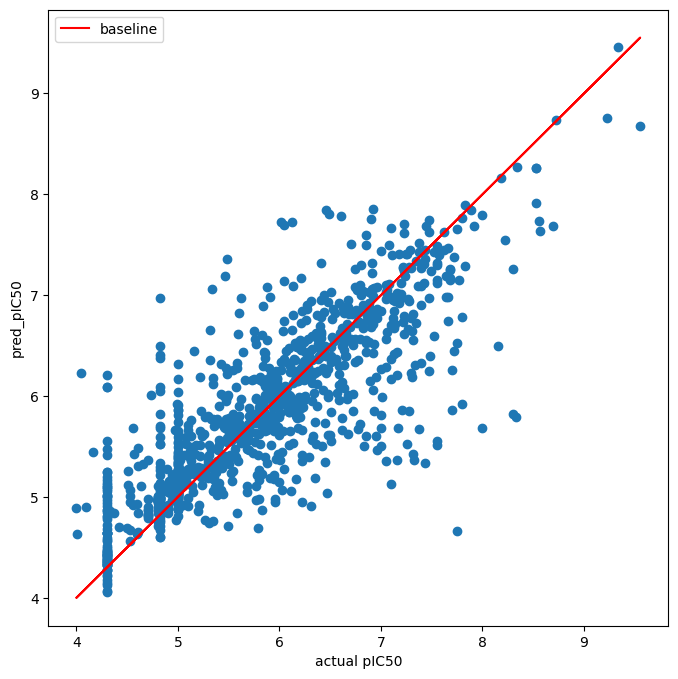

In [70]:
y_baseline = x
fig = plt.figure(figsize=(8,8))
plt.scatter(x, y)
plt.plot(x, y_baseline, label = 'baseline', color = 'r')
plt.legend()
plt.xlabel('actual pIC50')
plt.ylabel('pred_pIC50')
plt.show

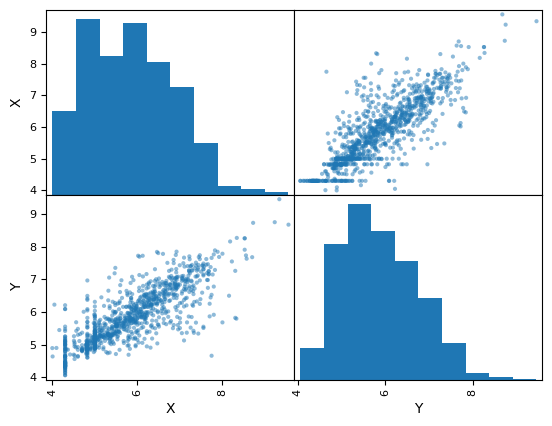

pearson系数: 0.8156515385814846
P-Value: 2.0039217430517237e-239


In [71]:
pred_results = pd.DataFrame({"X":x,"Y":y})
pd.plotting.scatter_matrix(pred_results)
plt.show()

r = pearsonr(pred_results['X'],pred_results['Y'])
print("pearson系数:",r[0])
print("P-Value:",r[1])


In [72]:
print(r2_score(x, y))

0.6630578309229207
